In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

In [3]:
# Code extended from the following source: https://www.tensorflow.org/tutorials/text/nmt_with_attention
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.test.is_gpu_available()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import concurrent.futures
import collections
import unicodedata
import re
import numpy as np
import os
import io
import sys
import math
import time

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
#########################################
# RNN ENCODER-DECODER 
#########################################
#https://stackoverflow.com/questions/55490830/how-to-set-an-initial-state-for-a-bidirectional-lstm-layer-in-keras
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # tell LSTM you want to get the states, and sequences returned
        self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))


    def call(self, x, hidden):
        x = self.embedding(x)
        # no need to pass [hidden, hidden], just pass it as is
        output, forward_h, forward_c, backward_h, backward_c = self.lstmb(x, initial_state=hidden)
        return output, forward_h, forward_c, backward_h, backward_c


    def initialize_hidden_state(self):
        # I stole this idea from iamlcc, so the credit is not mine.
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dec_units,    
                                                                    return_sequences=True,
                                                                    return_state=True,
                                                                    dropout=0.1,
                                                                    go_backwards= True))

    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, initial_state):
    x = self.embedding(x)

    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    
    x, h, c, b, b_c = self.lstmb(x, initial_state = initial_state)
    states = tf.concat([h, b], axis=1)
    output = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc(output)
    return x, states, attention_weights
    

In [4]:
#########################################
# TEXT PROCESSING
#########################################
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,Ã‚Â¿])", r" \1 ", w)
  w = re.sub(r'[" "]', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,Ã‚Â¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]
  #print(word_pairs)
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path):
  inp_lang, targ_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(root_path + path_to_data_train)
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
#print(len(input_tensor_train), len(target_tensor_train))

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

#print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
#print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

1 ----> <start>
4 ----> domain=music
16 ----> <sod>
29 ----> can
11 ----> you
36 ----> find
33 ----> song
65 ----> s
72 ----> from
53 ----> $artist
65 ----> s
463 ----> ablum
64 ----> $album
8 ----> ?
2 ----> <end>

1 ----> <start>
12 ----> i
65 ----> found
34 ----> $count
13 ----> song
25 ----> from
16 ----> $artist
67 ----> s
17 ----> $album
22 ----> album
3 ----> .
4 ----> the
13 ----> song
10 ----> is
8 ----> $song
6 ----> name
3 ----> .
2 ----> <end>


In [ ]:
#########################################
# TRAINING
#########################################

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0


  with tf.GradientTape() as tape:
    enc_output, enc_hidden, forward_c, backward_h, backward_c = encoder(inp, enc_hidden) 

    encoder_state = [enc_hidden, forward_c, backward_h, backward_c]

    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]): #Shape is wrong?
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, initial_state= encoder_state)
      loss += loss_function(targ[:, t], predictions)      

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss, acc

def train_model(EPOCHS):
    loss_plot = []
    
    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss, acc = train_step(inp, targ, enc_hidden) #Breaks here
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        if (epoch + 1) == 25:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        loss_plot.append(total_loss/steps_per_epoch)
        plt.plot(loss_plot, 'r')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


In [ ]:
#########################################
# EVALUATION
#########################################

def evaluate(sentence, candidate=None, id=None):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = []
    for word in sentence.split(' '):
        if word in inp_lang.word_index:
            inputs.append(inp_lang.word_index[word])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    value = 0

    hidden = [tf.zeros((1, units)) for i in range(4)]

    enc_out, forward_h, forward_c, backward_h, backward_c = encoder(inputs, hidden)

    encoder_state = [forward_h, forward_c, backward_h, backward_c]
    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    candidate_words = []
    if candidate != None:
        candidate = candidate + " <end>"
        for word in candidate.split(' '):
            if word in targ_lang.word_index:
                candidate_words.append(targ_lang.word_index[word])

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, initial_state = encoder_state)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        if candidate == None:
            predicted_id = tf.argmax(predictions[0]).numpy()
        else:
            predicted_id = candidate_words[t]

        value += predictions[0][predicted_id].numpy()

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, value/t, id, sentence, attention_plot

        result += targ_lang.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, value/t, id, sentence, attention_plot

def loadTestData(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    lines = text.strip().split('\n')

    allCandidates = []
    candidates = []
    contexts = []

    for i in range(0, len(lines)):
        if lines[i].startswith("CONTEXT:"): 
            candidate = lines[i][8:]
            contexts.append(candidate)
            continue
            
        elif len(lines[i].strip()) == 0:
            if i>0: allCandidates.append(candidates)
            candidates = []
            
        else:
            candidate = lines[i][12:]
            candidates.append(candidate)
    
    allCandidates.append(candidates)
    return allCandidates, contexts

def getRankValue(target_value, unsorted_distribution):
    sorted_distribution = sorted(unsorted_distribution, reverse=True)
    #print("sorted_distribution="+str(sorted_distribution))
    for i in range (0, len(sorted_distribution)):
        value = sorted_distribution[i]
        #print("value(rank"+str((i+1))+")="+str(value)+" <==> target="+str(target_value))
        if value == target_value: 
            return 1/(i+1)
    return None
    
def evaluate_model(filename_testdata, checkpoint_dir):
    f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted.txt", 'w')
    f_reference = open(checkpoint_dir+"/dstc8-sgd-reference.txt", 'w')
    
    candidates, contexts = loadTestData(filename_testdata)
    correct_predictions = 0
    total_predictions = 0
    cumulative_mrr = 0
    recall_at_1 = None
    mrr = None

    for i in range(0, len(contexts)):
        total_predictions += 1
        #best_value = 0
        #best_index = 0
        response = ""
        response_value = 0
        response_attention_plot = []
        target_value = 0
        context = contexts[i]
        reference = candidates[i][0]
        distribution = []
        jobs = []

        with concurrent.futures.ThreadPoolExecutor() as executor:
            jobs.append(executor.submit(evaluate, preprocess_sentence(context), None, 0))
            for j in range (0,len(candidates[i])):
                jobs.append(executor.submit(evaluate, preprocess_sentence(context), candidates[i][j], (j+1)))
        
        for future in concurrent.futures.as_completed(jobs):
            candidate_sentence, value_candidate, id, inp_sentence, attention_plot = future.result()
            if id == 0:
                response = candidate_sentence
                response_value = value_candidate
                response_attention_plot = attention_plot
                #print(str(i+1)+' '+str(id)+' predicted_sentence:', candidate_sentence, 'value:', value_candidate) 
            else:
                distribution.append(value_candidate)
                #print(str(i+1)+' '+str(id)+' candidate_sentence:', candidate_sentence, 'value:', value_candidate) 

            if id == 1: target_value = value_candidate

            #if value_candidate > best_value:
            #    best_value = value_candidate
            #    best_index = id

        rank = getRankValue(target_value, distribution)
        cumulative_mrr += rank
        correct_predictions += 1 if rank == 1 else 0
        
        recall_at_1 = correct_predictions/total_predictions
        mrr = cumulative_mrr/total_predictions
        #print(str(i)+' INPUT='+str(context)+' PREDICTED='+str(response)+' REFERENCE='+str(reference)+' CumulativeR@1='+str(recall_at_1)+' ('+str(correct_predictions)+' out of '+str(total_predictions)+') CumulativeMRR='+str(mrr)+' ('+str(cumulative_mrr)+' out of '+str(total_predictions)+')')
        #print("")
        #plot_attention(response_attention_plot, context.split(' '), response.split(' '))

        f_predicted.write(response+"\n")
        f_reference.write(reference+"\n")
    
    f_predicted.close()
    f_reference.close()

    print("BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under "+str(checkpoint_dir))
    print("RECALL@1="+str(recall_at_1))
    print("Mean Reciprocal Rank="+str(mrr))
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Training
Epoch 1 Batch 0 Loss 2.0476
Epoch 1 Loss 1.4017
Time taken for 1 epoch 116.04547834396362 sec



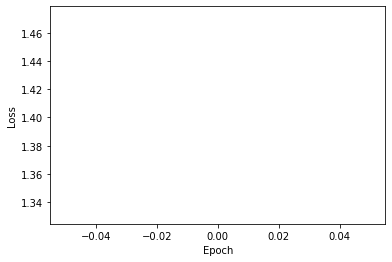

Epoch 2 Batch 0 Loss 0.8799
Epoch 2 Loss 0.9135
Time taken for 1 epoch 35.690837144851685 sec



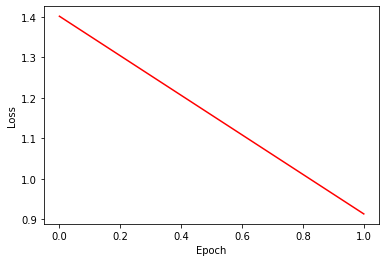

Epoch 3 Batch 0 Loss 0.8095
Epoch 3 Loss 0.6954
Time taken for 1 epoch 35.68148875236511 sec



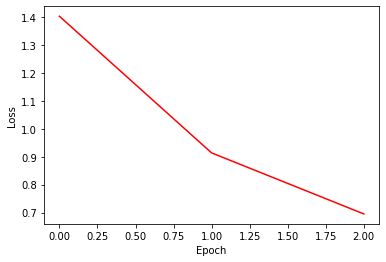

Epoch 4 Batch 0 Loss 0.7564
Epoch 4 Loss 0.6033
Time taken for 1 epoch 35.71229147911072 sec



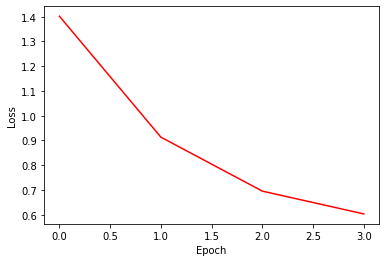

Epoch 5 Batch 0 Loss 0.6381
Epoch 5 Loss 0.5278
Time taken for 1 epoch 35.732455015182495 sec



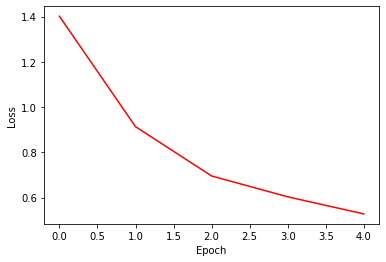

Epoch 6 Batch 0 Loss 0.4288
Epoch 6 Loss 0.4804
Time taken for 1 epoch 35.70056390762329 sec



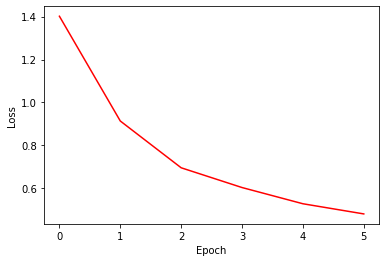

Epoch 7 Batch 0 Loss 0.4972
Epoch 7 Loss 0.4484
Time taken for 1 epoch 35.71082305908203 sec



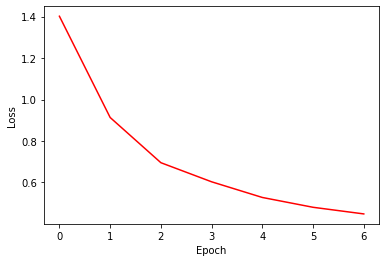

Epoch 8 Batch 0 Loss 0.4505
Epoch 8 Loss 0.4253
Time taken for 1 epoch 35.69107413291931 sec



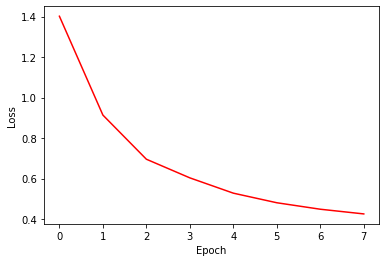

Epoch 9 Batch 0 Loss 0.3778
Epoch 9 Loss 0.4042
Time taken for 1 epoch 35.69346499443054 sec



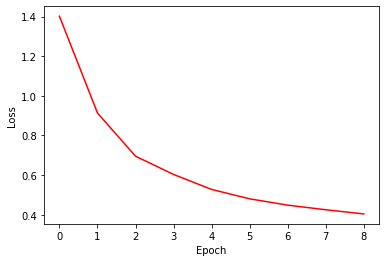

Epoch 10 Batch 0 Loss 0.3817
Epoch 10 Loss 0.3862
Time taken for 1 epoch 35.70803380012512 sec



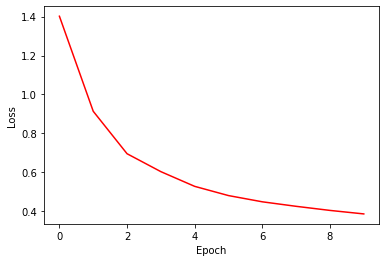

Epoch 11 Batch 0 Loss 0.3603
Epoch 11 Loss 0.3755
Time taken for 1 epoch 35.70245003700256 sec



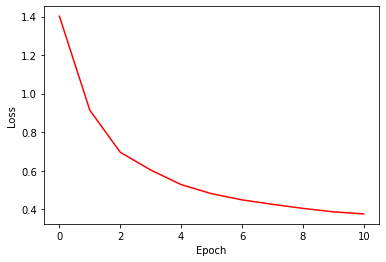

Epoch 12 Batch 0 Loss 0.4093
Epoch 12 Loss 0.3608
Time taken for 1 epoch 35.72527289390564 sec



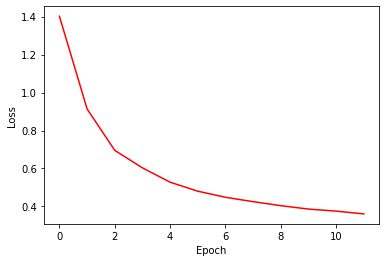

Epoch 13 Batch 0 Loss 0.3169
Epoch 13 Loss 0.3470
Time taken for 1 epoch 35.7196261882782 sec



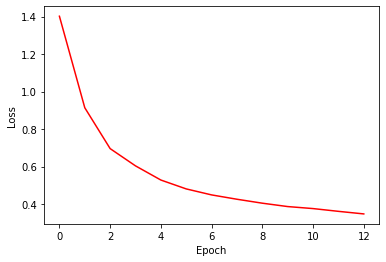

Epoch 14 Batch 0 Loss 0.3050
Epoch 14 Loss 0.3334
Time taken for 1 epoch 35.718332290649414 sec



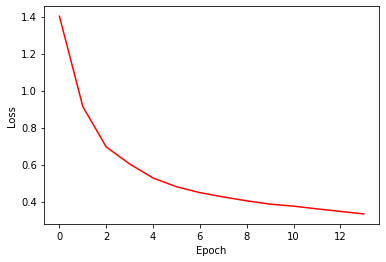

Epoch 15 Batch 0 Loss 0.2893
Epoch 15 Loss 0.3226
Time taken for 1 epoch 35.706767320632935 sec



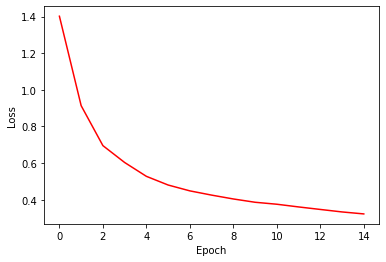

Epoch 16 Batch 0 Loss 0.3325
Epoch 16 Loss 0.3094
Time taken for 1 epoch 35.70740556716919 sec



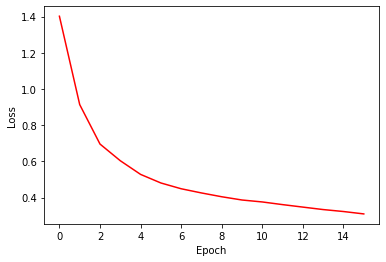

Epoch 17 Batch 0 Loss 0.2644
Epoch 17 Loss 0.2971
Time taken for 1 epoch 35.70033574104309 sec



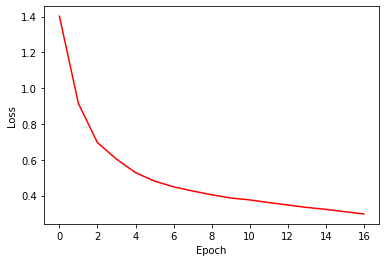

Epoch 18 Batch 0 Loss 0.3012
Epoch 18 Loss 0.2824
Time taken for 1 epoch 35.70553660392761 sec



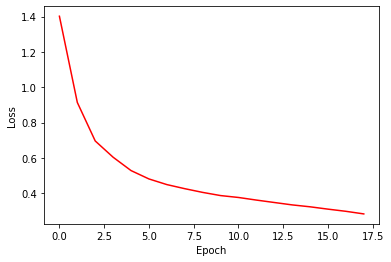

Epoch 19 Batch 0 Loss 0.2037
Epoch 19 Loss 0.2678
Time taken for 1 epoch 35.72373366355896 sec



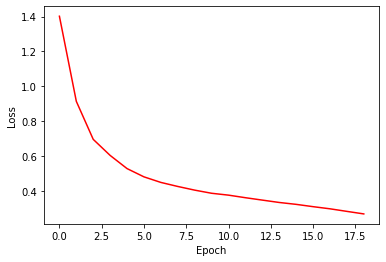

Epoch 20 Batch 0 Loss 0.2457
Epoch 20 Loss 0.2542
Time taken for 1 epoch 35.7065794467926 sec



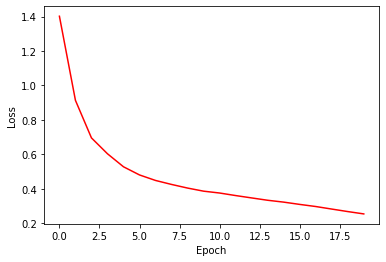

Epoch 21 Batch 0 Loss 0.2287
Epoch 21 Loss 0.2369
Time taken for 1 epoch 35.70137119293213 sec



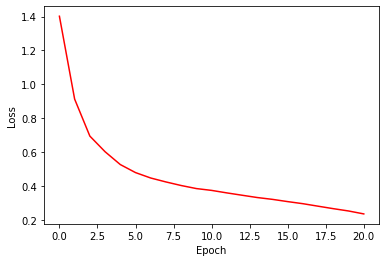

Epoch 22 Batch 0 Loss 0.2028
Epoch 22 Loss 0.2223
Time taken for 1 epoch 35.709176540374756 sec



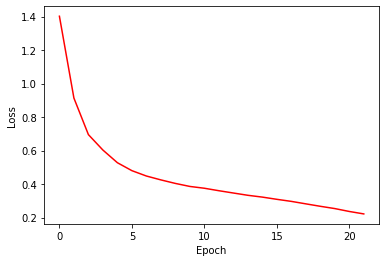

Epoch 23 Batch 0 Loss 0.2169
Epoch 23 Loss 0.2055
Time taken for 1 epoch 35.70236563682556 sec



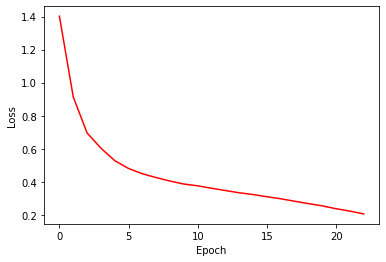

Epoch 24 Batch 0 Loss 0.1603
Epoch 24 Loss 0.1902
Time taken for 1 epoch 35.711100339889526 sec



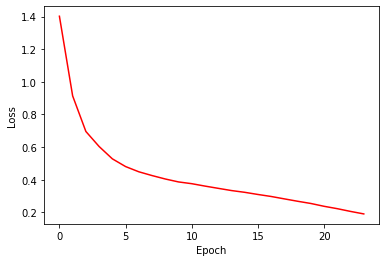

Epoch 25 Batch 0 Loss 0.1527
Epoch 25 Loss 0.1740
Time taken for 1 epoch 37.526103496551514 sec



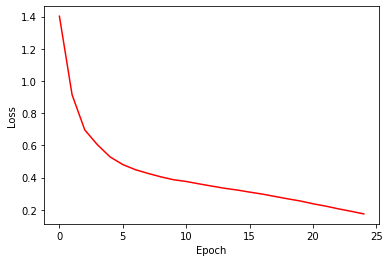

Validation
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.601010101010101
Mean Reciprocal Rank=0.7543655804072467
Testing
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.47551020408163264
Mean Reciprocal Rank=0.654695497246518
Execution time=4602.366136550903 secs.


In [ ]:
#########################################
# MAIN PROGRAM
#########################################
start_exec_time = time.time()
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)


sample_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, initial_state = [forward_h, forward_c, backward_h, backward_c])

checkpoint_dir = root_path + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

epoch = 25
for filename in os.listdir(checkpoint_dir):
  print("Erasing file " +str(filename))
  os.remove(checkpoint_dir + "/" + filename)
print("Training")
train_model(epoch)
print("Validation")
evaluate_model(root_path + path_to_data_val, checkpoint_dir)
print("Testing")
evaluate_model(root_path + path_to_data_test, checkpoint_dir)

exec_time = time.time() - start_exec_time
print("Execution time="+str(exec_time)+" secs.")